In [2]:
# %matplotlib inline
# %matplotlib widget
# %matplotlib notebook

import warnings
warnings.filterwarnings(action='ignore')

import sys
sys.path.append('../configs/')
sys.path.append('../helper/')
sys.path.append('../models/')
sys.path.append('../data/')

import torch
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import glob
import random
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
import importlib
from ml_collections import config_flags
from absl import app
from absl import flags
from sklearn.metrics import explained_variance_score
from tqdm import tqdm

import models
import helper_functions as hpfn
import configs_model_natural as confmn
import configs_model_natural_inverted as confmni
import configs_model_natural_phase_randomized as confmnpr
import configs_model_gaussian as confmg
import moving_edges
import sawtooth_gradient


In [3]:
importlib.reload(confmn)

# get lists of hyper parameters
config = confmn.get_config()
D_cnn_list = config.D_cnn_list # list of depth
C_list = config.C_list # list of number of independent channels
Repeat = config.Repeat # repeat for different initializations
activationf = config.activationf # activation functions, which can be 'ReLU', 'LeakyReLU' or 'ELU'.
T = config.T # length in time (one for 10 ms)
od = config.od

figure_folder_paper = '../results/figures_for_paper/'
if not os.path.exists(figure_folder_paper):
    os.makedirs(figure_folder_paper)
    
variable_folder_paper = '../results/variables_for_paper/'
if not os.path.exists(variable_folder_paper):
    os.makedirs(variable_folder_paper)



In [4]:
color_list4 = [[27/255, 158/255, 119/255], [217/255, 95/255, 2/255], [117/255, 112/255, 179/255], [231/255, 41/255, 138/255]]


In [5]:
importlib.reload(hpfn)

# moving edges
def get_one_white_moving_edge(vv, p, rescalev=0.1):
    K_row = 1
    K_col = 720
    pix_per_deg = K_col / 360
    FWHM = 5 # in degree
    sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian
    delta_t = 0.01 # simulation step is 0.01 second
    
    T = int((360/p)/vv*100)
    synthetic_data_white_edge = np.zeros((10, T, 1, 72))
    vel = np.ones(T-1) * vv
    
    img = -rescalev * np.ones((K_row, K_col))
    for ii in range(p):
        img[:, ii*int(720/p)] = rescalev
    _, shift_array_pix = hpfn.get_shift_array(vel, delta_t, img)
    for tt, shift in enumerate(shift_array_pix):
        for ii in range(p):
            img[:, ii*int(720/p):ii*int(720/p)+shift] = rescalev
        img_filtered = hpfn.get_filtered_spacial_row(img, sigma_for_gaussian, 'reflect')
        for xx in range(10):
            synthetic_data_white_edge[xx, tt, :, :] = img_filtered[:, xx::10]
            
    synthetic_data_black_edge = -synthetic_data_white_edge
    
    return synthetic_data_white_edge, synthetic_data_black_edge


# phase shift in time
def get_white_moving_edge_phaseshift(vv, p, rescalev=0.1):
    T = int((360/p)/vv*100)
    synthetic_data_white_edge, _ = get_one_white_moving_edge(vv=vv, p=p, rescalev=rescalev)
    phase_shift_total = T
    synthetic_data_white_edge_phase = np.zeros((int(10*T), 50, 1, 72))
    for phase_shift in range(phase_shift_total):
        synthetic_data_white_edge_phase[phase_shift*10:(phase_shift+1)*10, :, :, :] = np.roll(synthetic_data_white_edge, shift=phase_shift, axis=1)[:, :50, :, :]
    
    return synthetic_data_white_edge_phase


# gradient
def get_one_right_left_sawtooth(xtess, rescalev=0.1):
    K_col = 720
    pix_per_deg = K_col / 360
    FWHM = 5 # in degree
    sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian

    stim_bundler = np.zeros((10, 50, 1, 72))
    stimr = sawtooth_gradient.get_bitmap(direction = 'r', xtess = xtess, x = 720, t = 50)
    stimr = hpfn.get_filtered_spacial_row(stimr, sigma_for_gaussian)
    for xx in range(10):
        stim_bundler[xx, :, 0, :] = stimr[:, xx::10] * rescalev

    stim_bundlel = np.zeros((10, 50, 1, 72))
    stiml = sawtooth_gradient.get_bitmap(direction = 'l', xtess = xtess, x = 720, t = 50)
    stiml = hpfn.get_filtered_spacial_row(stiml, sigma_for_gaussian)
    for xx in range(10):
        stim_bundlel[xx, :, 0, :] = stiml[:, xx::10] * rescalev
        
    return stim_bundler, stim_bundlel

In [25]:
def CLT_binary_tree(T):
    A = 0
    for t in range(T):
        A = A + 2 ** (-t) * np.sign(np.random.random()-0.5)
    return A


def CLT_binary_tree_normal(T):
    A = 0
    for t in range(T):
        A = A + 2 ** (-t) * np.random.randn()
    return A

In [26]:
N = 100000
T = 100
leaves = np.zeros(N)
for n in range(N):
    leaves[n] = CLT_binary_tree(T)

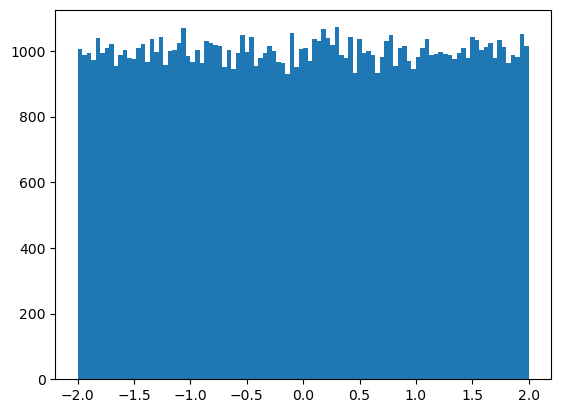

In [27]:
plt.hist(leaves, 100)
plt.show()

In [28]:
N = 100000
T = 100
leaves = np.zeros(N)
for n in range(N):
    leaves[n] = CLT_binary_tree_normal(T)
    

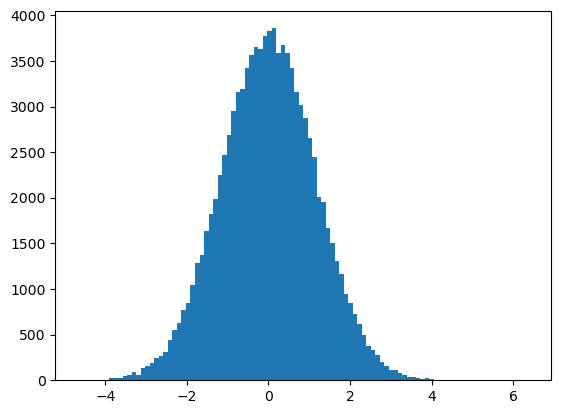

In [29]:
plt.hist(leaves, 100)
plt.show()

#### Sinewave

In [68]:
def get_sin_wave_old(k, v, L, T, phi=0, dt=0.01, resize=72):
    """
    Args:
    k: wave number, rad/deg
    v: deg/sec
    L: length of the long dimension, deg
    T: length of time step
    phi: phase
    dt: temporal resolution, sec
    """
    x = np.arange(1, L+1)
    scene_1d = np.sin(k * (x + phi))
    scene_1d = scene_1d.reshape((1, -1)) * 0.05
    scene_1d = hpfn.get_filtered_spacial_row(scene_1d, 5)
    
    xt_plot = np.zeros((T, 1, resize))
    for t in range(T):
        xt_plot[t, 0] = hpfn.get_resized(np.roll(scene_1d, int(np.round(v * dt * t)), axis=1), n_row=1, n_col=resize)

    return xt_plot




def get_one_sin_wave(k, v, T, phi=0, rescalev=0.05):
    K_row = 1
    K_col = 720
    pix_per_deg = K_col / 360
    FWHM = 5 # in degree
    sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian
    delta_t = 0.01 # simulation step is 0.01 second
    
    T = 50
    synthetic_data_sinwave = np.zeros((10, T, 1, 72))
    vel = np.ones(T-1) * v
    
    x = np.linspace(0, 360, K_col)
    img = np.sin(k * (x + phi))
    img = img.reshape((1, -1)) * rescalev

    _, shift_array_pix = hpfn.get_shift_array(vel, delta_t, img)
    for tt, shift in enumerate(shift_array_pix):
        img_rolled = np.roll(img, shift, axis=1)
        img_filtered = hpfn.get_filtered_spacial_row(img_rolled, sigma_for_gaussian, 'reflect')
        for xx in range(10):
            synthetic_data_sinwave[xx, tt, :, :] = img_filtered[:, xx::10]
    
    return synthetic_data_sinwave



In [94]:
k = np.pi / 180 * 8
v = 60
T = 50
xt_plot_sinwave = get_one_sin_wave(k, v, T)
print(xt_plot_sinwave.shape)

(10, 50, 1, 72)


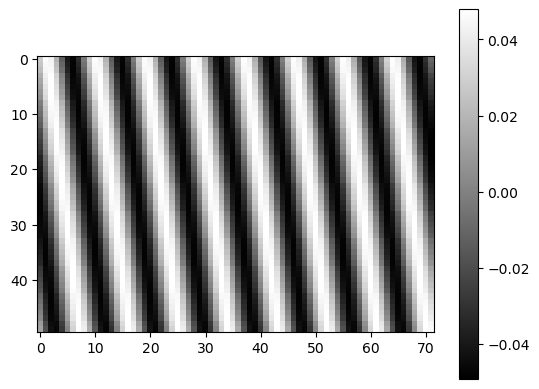

In [95]:
plt.imshow(xt_plot_sinwave[9].squeeze(), 'gray')
plt.colorbar()
plt.show()

In [99]:
model_folder_list = ['../results/trained_models_natural_original/', 
                     '../results/trained_models_natural_inverted/',
                     '../results/trained_models_natural_phase_randomized/',
                     '../results/trained_models_gaussian/']

D_cnn_list = [1, 2, 3, 4]
C_list = [2, 4]

########
sinwave_results_all = 3.1415926 * np.ones((4, len(C_list), len(D_cnn_list), 500))

for indm, model_folder in enumerate(model_folder_list):
    for indC, C in enumerate(tqdm(C_list)):
        for indD, D_cnn in enumerate(D_cnn_list):
            for R in range(500):
                model_path = model_folder + f'Dcnn{D_cnn}_C{C}_' + activationf + f'_R{R+1}/'
                if os.path.exists(model_path + f'model.pth'):
                    network = models.CNNSpaceInvLRSymm(D_cnn=D_cnn, C=C, od=1, activationf='ReLU', T=50)
                    network.load_state_dict(torch.load(model_path + f'model.pth'))
                    # define the input
                    inputs = xt_plot_sinwave.copy()

                    # feed the input into the model and get the predicted velocity
                    inputs_torch = torch.from_numpy(inputs).float()
                    outputs = network(inputs_torch)
                    outputs = outputs.detach().numpy()

                    mean_ = np.round_(outputs.mean(), 3)
                    sinwave_results_all[indm, indC, indD, R] = mean_
np.save(f'../results/variables_for_paper/sinwave_results_all_test', sinwave_results_all)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [08:47<00:00, 263.86s/it]


In [101]:
model_folder_list = ['../results/trained_models_cauchy/', 
                     '../results/trained_models_laplace/']

D_cnn_list = [1, 2, 3, 4]
C_list = [2, 4]

########
sinwave_results_all = 3.1415926 * np.ones((2, len(C_list), len(D_cnn_list), 100))

for indm, model_folder in enumerate(model_folder_list):
    for indC, C in enumerate(tqdm(C_list)):
        for indD, D_cnn in enumerate(D_cnn_list):
            for R in range(100):
                model_path = model_folder + f'Dcnn{D_cnn}_C{C}_' + activationf + f'_R{R+1}/'
                if os.path.exists(model_path + f'model.pth'):
                    network = models.CNNSpaceInvLRSymm(D_cnn=D_cnn, C=C, od=1, activationf='ReLU', T=50)
                    network.load_state_dict(torch.load(model_path + f'model.pth'))
                    # define the input
                    inputs = xt_plot_sinwave.copy()

                    # feed the input into the model and get the predicted velocity
                    inputs_torch = torch.from_numpy(inputs).float()
                    outputs = network(inputs_torch)
                    outputs = outputs.detach().numpy()

                    mean_ = np.round_(outputs.mean(), 3)
                    sinwave_results_all[indm, indC, indD, R] = mean_
np.save(f'../results/variables_for_paper/sinwave_results_all_test_cauchy_laplace', sinwave_results_all)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.66s/it]


In [100]:
sinwave_results_all

(4, 2, 4, 500)

(10, 50, 1, 72)
(10, 50, 1, 72)


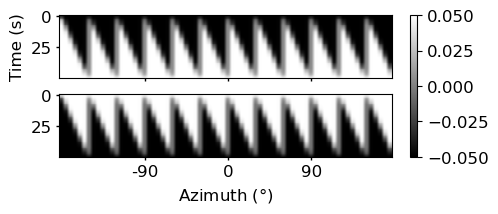

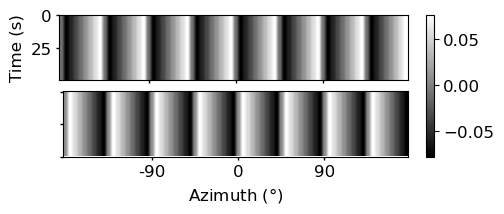

In [22]:
synthetic_data_white_edge, synthetic_data_black_edge = get_one_white_moving_edge(vv=60, p=12, rescalev=0.05)
stim_bundler, stim_bundlel = get_one_right_left_sawtooth(xtess=8, rescalev=0.1)
print(synthetic_data_white_edge.shape) 
print(stim_bundler.shape)


# plot
font_size = 12
label_size = 12

# moving edges
fig = plt.figure(figsize=(5, 1.5*5*97.5/360), constrained_layout=True)
gs = GridSpec(2, 1, figure=fig)

axes_list = []
ax = fig.add_subplot(gs[0, 0])
axes_list.append(ax)
im = ax.imshow(synthetic_data_white_edge[0].squeeze(), 'gray')
ax.set_xticks([18, 36, 54])
ax.set_xticklabels([])
ax.set_ylabel('Time (s)', fontsize=font_size)
ax.tick_params(direction='out', length=2, width=1, labelsize=label_size)
ax.set_aspect(97.5/360)

ax = fig.add_subplot(gs[1, 0])
axes_list.append(ax)
im = ax.imshow(synthetic_data_black_edge[0].squeeze(), 'gray')
ax.set_xticks([18, 36, 54])
ax.set_xticklabels([-90, 0, 90])
ax.set_xlabel(r'Azimuth ($\degree$)', fontsize=font_size)
ax.tick_params(direction='out', length=2, width=1, labelsize=label_size)
ax.set_aspect(97.5/360)

cbar = plt.colorbar(im, ax=axes_list, orientation='vertical', fraction=.027)
cbar.ax.tick_params(labelsize=label_size)

plt.show()


# sawtooth
fig = plt.figure(figsize=(5, 1.5*5*97.5/360), constrained_layout=True)
gs = GridSpec(2, 1, figure=fig)

axes_list = []
ax = fig.add_subplot(gs[0, 0])
axes_list.append(ax)
im = ax.imshow(stim_bundler[0].squeeze(), 'gray')
ax.set_xticks([18, 36, 54])
ax.set_xticklabels([])
ax.set_ylabel('Time (s)', fontsize=font_size)
ax.tick_params(direction='out', length=2, width=1, labelsize=label_size)
ax.set_aspect(97.5/360)

ax = fig.add_subplot(gs[1, 0])
axes_list.append(ax)
im = ax.imshow(stim_bundlel[0].squeeze(), 'gray')
ax.set_yticks([0, 25, 50])
ax.set_yticklabels([])
ax.set_xticks([18, 36, 54])
ax.set_xticklabels([-90, 0, 90])
ax.set_xlabel(r'Azimuth ($\degree$)', fontsize=font_size)
ax.tick_params(direction='out', length=2, width=1, labelsize=label_size)
ax.set_aspect(97.5/360)

cbar = plt.colorbar(im, ax=axes_list, orientation='vertical', fraction=.027)
cbar.ax.tick_params(labelsize=label_size)

plt.show()


In [23]:
synthetic_data_white_edge_phase = get_white_moving_edge_phaseshift(vv=60, p=12, rescalev=0.05) 
synthetic_data_black_edge_phase = -synthetic_data_white_edge_phase

print(synthetic_data_white_edge_phase.shape)


(500, 50, 1, 72)


In [1]:
# moving edges
fig = plt.figure(figsize=(5, 2*1.5*5*97.5/360), constrained_layout=True)
gs = GridSpec(4, 1, figure=fig)

axes_list = []
ax = fig.add_subplot(gs[0, 0])
axes_list.append(ax)
im = ax.imshow(synthetic_data_white_edge_phase[0].squeeze(), 'gray')
ax.set_xticks([18, 36, 54])
ax.set_xticklabels([])
ax.set_ylabel('Time (s)', fontsize=font_size)
ax.tick_params(direction='out', length=2, width=1, labelsize=label_size)
ax.set_aspect(97.5/360)

ax = fig.add_subplot(gs[1, 0])
axes_list.append(ax)
im = ax.imshow(synthetic_data_white_edge_phase[100].squeeze(), 'gray')
ax.set_xticks([18, 36, 54])
ax.set_xticklabels([])
ax.tick_params(direction='out', length=2, width=1, labelsize=label_size)
ax.set_aspect(97.5/360)

ax = fig.add_subplot(gs[2, 0])
axes_list.append(ax)
im = ax.imshow(synthetic_data_white_edge_phase[300].squeeze(), 'gray')
ax.set_xticks([18, 36, 54])
ax.set_xticklabels([])
ax.tick_params(direction='out', length=2, width=1, labelsize=label_size)
ax.set_aspect(97.5/360)

ax = fig.add_subplot(gs[3, 0])
axes_list.append(ax)
im = ax.imshow(synthetic_data_white_edge_phase[400].squeeze(), 'gray')
ax.set_xticks([18, 36, 54])
ax.set_xticklabels([-90, 0, 90])
ax.set_xlabel(r'Azimuth ($\degree$)', fontsize=font_size)
ax.tick_params(direction='out', length=2, width=1, labelsize=label_size)
ax.set_aspect(97.5/360)

cbar = plt.colorbar(im, ax=axes_list, orientation='vertical', fraction=.027)
cbar.ax.tick_params(labelsize=label_size)

plt.show()

NameError: name 'plt' is not defined

#### Moving edge screening

In [5]:
rescalev_list_edge = [0.02, 0.05, 0.1, 0.2, 0.4]
v_list = [10, 20, 30, 40, 50, 60]

model_folder_list = ['../results/trained_models_natural_original/', 
                     '../results/trained_models_natural_inverted/',
                     '../results/trained_models_natural_phase_randomized/',
                     '../results/trained_models_gaussian/']

D_cnn_list = [1, 2, 3, 4]
C_list = [2, 4]

########
moving_edges_results_all = 3.1415926 * np.ones((4, len(C_list), len(D_cnn_list), len(rescalev_list_edge), len(v_list), 500, 2))

for indm, model_folder in enumerate(model_folder_list):
    for indC, C in enumerate(tqdm(C_list)):
        for indD, D_cnn in enumerate(D_cnn_list):
            for R in range(500):
                model_path = model_folder + f'Dcnn{D_cnn}_C{C}_' + activationf + f'_R{R+1}/'
                if os.path.exists(model_path + f'model.pth'):
                    network = models.CNNSpaceInvLRSymm(D_cnn=D_cnn, C=C, od=1, activationf='ReLU', T=50)
                    network.load_state_dict(torch.load(model_path + f'model.pth'))
                    # moving edges
                    for kk in range(len(rescalev_list_edge)):
                        for ii in range(len(v_list)):
                            vv = v_list[ii]
                            resc = rescalev_list_edge[kk]
                            synthetic_data_white_edge_phase = get_white_moving_edge_phaseshift(vv=vv, p=12, rescalev=resc) 
                            synthetic_data_black_edge_phase = -synthetic_data_white_edge_phase

                            for ind2, stim_cat in enumerate([synthetic_data_white_edge_phase, synthetic_data_black_edge_phase]):

                                # define the input
                                inputs = stim_cat.copy()

                                # feed the input into the model and get the predicted velocity
                                inputs_torch = torch.from_numpy(inputs).float()
                                outputs = network(inputs_torch)
                                outputs = outputs.detach().numpy()

                                mean_ = np.round_(outputs.mean(), 3)
                                moving_edges_results_all[indm, indC, indD, kk, ii, R, ind2] = mean_
np.save(f'../results/variables_for_paper/moving_edges_results_all_test', moving_edges_results_all)
    
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [3:45:04<00:00, 6752.11s/it]


In [17]:
# moving_edges_results_all_005 = np.load(f'../results/variables_for_paper/moving_edges_results_all1.25_500_005.npy')
# moving_edges_results_all_500 = np.load(f'../results/variables_for_paper/moving_edges_results_all1.25_500.npy')

# print(moving_edges_results_all_005.shape)
# print(moving_edges_results_all_500.shape)

# moving_edges_results_all = np.concatenate((moving_edges_results_all_005, moving_edges_results_all_500), axis=3)
# np.save(f'../results/variables_for_paper/moving_edges_results_all', moving_edges_results_all)
# print(moving_edges_results_all.shape)

(4, 2, 4, 1, 6, 500, 2)
(4, 2, 4, 3, 6, 500, 2)
(4, 2, 4, 4, 6, 500, 2)


#### Sawtooth screening

In [8]:
rescalev_list = [0.05, 0.08, 0.1, 0.12, 0.16, 0.18, 0.2]

model_folder_list = ['../results/trained_models_natural_original/', 
                     '../results/trained_models_natural_inverted/',
                     '../results/trained_models_natural_phase_randomized/',
                     '../results/trained_models_gaussian/']

D_cnn_list = [1, 2, 3, 4]
C_list = [2, 4]

########
gradient_results_all = np.zeros((4, len(C_list), len(D_cnn_list), len(rescalev_list), 500, 2))

for indm, model_folder in enumerate(model_folder_list):
    for indC, C in enumerate(tqdm(C_list)):
        for indD, D_cnn in enumerate(D_cnn_list):
            for R in range(500):
                model_path = model_folder + f'Dcnn{D_cnn}_C{C}_' + activationf + f'_R{R+1}/'
                if os.path.exists(model_path + f'model.pth'):
                    network = models.CNNSpaceInvLRSymm(D_cnn=D_cnn, C=C, od=1, activationf='ReLU', T=50)
                    network.load_state_dict(torch.load(model_path + f'model.pth'))
                    # moving edges
                    for kk in range(len(rescalev_list)):
                        resc = rescalev_list[kk]
                        stim_bundler, stim_bundlel = get_one_right_left_sawtooth(xtess=8, rescalev=resc)

                        for ind2, stim_cat in enumerate([stim_bundler, stim_bundlel]):

                            # define the input
                            inputs = stim_cat.copy()

                            # feed the input into the model and get the predicted velocity
                            inputs_torch = torch.from_numpy(inputs).float()
                            outputs = network(inputs_torch)
                            outputs = outputs.detach().numpy()

                            mean_ = np.round_(outputs.mean(), 3)
                            gradient_results_all[indm, indC, indD, kk, R, ind2] = mean_
np.save(f'../results/variables_for_paper/gradient_results_all_test', gradient_results_all)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [04:41<00:00, 140.89s/it]


#### S14, S20

In [5]:
s_14 = [1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1]
s_14_shape = [4, 2]
s_20 = [1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1]
s_20_shape = [2, 4]

def get_S14S20(resc, s_, s_shape, timeR=False, contrastR=False):
    pix_per_deg = 720 / 360
    FWHM = 5 # in degree
    sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian
    S_raw = moving_edges.get_bitmap(s_, s_shape, xtess = 12, ttess = 1, t = 500) / 2 * resc
    
    if timeR:
        S_raw = S_raw[::-1, :]
    if contrastR:
        S_raw = -S_raw
        
    S_raw_filtered = hpfn.get_filtered_spacial_row(S_raw, sigma_for_gaussian, 'wrap')
    stimulus_50 = np.zeros((int(10*10), 50, 1, 72))
    indxy = 0
    for xx in range(10):
        for yy in range(10):
            stimulus_50[indxy, :, 0, :] = S_raw_filtered[xx::10, yy::10]
            indxy = indxy + 1
    
    stimulus_ = np.zeros((int(10*10*50), 50, 1, 72))
    for ii in range(50):
        stimulus_[ii*100:int(ii+1)*100] = np.roll(stimulus_50, ii, axis=1)
                
    return stimulus_, S_raw_filtered, S_raw

(5000, 50, 1, 72)


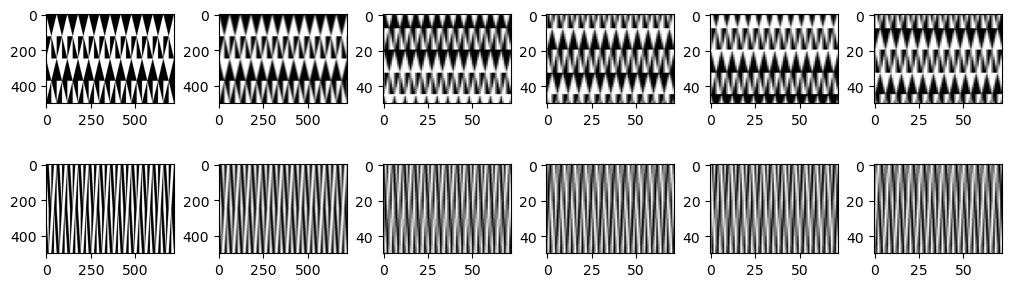

In [6]:
resc = 0.1
stimulus_14, S_raw_filtered_14, S_raw_14 = get_S14S20(resc, s_14, s_14_shape)
stimulus_20, S_raw_filtered_20, S_raw_20 = get_S14S20(resc, s_20, s_20_shape)
stimulus_14_theta, S_raw_filtered_14_theta, S_raw_14_theta = get_S14S20(resc, s_14, s_14_shape, timeR=True)
stimulus_20_theta, S_raw_filtered_20_theta, S_raw_20_theta = get_S14S20(resc, s_20, s_20_shape, timeR=True)
stimulus_14_gamma, S_raw_filtered_14_gamma, S_raw_14_gamma = get_S14S20(resc, s_14, s_14_shape, timeR=False, contrastR=True)
stimulus_20_gamma, S_raw_filtered_20_gamma, S_raw_20_gamma = get_S14S20(resc, s_20, s_20_shape, timeR=False, contrastR=True)
stimulus_14_gamma_theta, S_raw_filtered_14_gamma_theta, S_raw_14_gamma_theta = get_S14S20(resc, s_14, s_14_shape, timeR=True, contrastR=True)
stimulus_20_gamma_theta, S_raw_filtered_20_gamma_theta, S_raw_20_gamma_theta = get_S14S20(resc, s_20, s_20_shape, timeR=True, contrastR=True)
print(stimulus_14.shape)

indp = 2000
fig = plt.figure(figsize=(10, 3), constrained_layout=True)
gs = GridSpec(2, 6, figure=fig)

# s14, raw
ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(S_raw_14, 'gray')
# s14, raw, filtered
ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(S_raw_filtered_14, 'gray')
# s14
ax = fig.add_subplot(gs[0, 2])
im = ax.imshow(stimulus_14[indp].squeeze(), 'gray')
# s14, time reversal
ax = fig.add_subplot(gs[0, 3])
im = ax.imshow(stimulus_14_theta[indp].squeeze(), 'gray')
# s14, contrast reversal
ax = fig.add_subplot(gs[0, 4])
im = ax.imshow(stimulus_14_gamma[indp].squeeze(), 'gray')
# s14, time and contrast reversal
ax = fig.add_subplot(gs[0, 5])
im = ax.imshow(stimulus_14_gamma_theta[indp].squeeze(), 'gray')

# s20, raw
ax = fig.add_subplot(gs[1, 0])
im = ax.imshow(S_raw_20, 'gray')
# s20, raw, filtered
ax = fig.add_subplot(gs[1, 1])
im = ax.imshow(S_raw_filtered_20, 'gray')
# s20
ax = fig.add_subplot(gs[1, 2])
im = ax.imshow(stimulus_20[indp].squeeze(), 'gray')
# s20, time reversal
ax = fig.add_subplot(gs[1, 3])
im = ax.imshow(stimulus_20_theta[indp].squeeze(), 'gray')
# s20, contrast reversal
ax = fig.add_subplot(gs[1, 4])
im = ax.imshow(stimulus_20_gamma[indp].squeeze(), 'gray')
# s20, time and contrast reversal
ax = fig.add_subplot(gs[1, 5])
im = ax.imshow(stimulus_20_gamma_theta[indp].squeeze(), 'gray')

plt.show()


In [7]:
stimulus_1420 = np.zeros((2, )+stimulus_14.shape)
stimulus_1420[0] = stimulus_14
stimulus_1420[1] = stimulus_20
stimulus_1420.shape

(2, 5000, 50, 1, 72)

In [8]:
model_folder_list = ['../results/trained_models_natural_original/', 
                     '../results/trained_models_natural_inverted/',
                     '../results/trained_models_natural_phase_randomized/',
                     '../results/trained_models_gaussian/']

D_cnn_list = [1, 2, 3, 4]
C_list = [2, 4]
rescalev_list_edge = [0.05, 0.1, 0.2, 0.3, 0.4]

########
stimulus_1420_results_all = np.zeros((4, len(C_list), len(D_cnn_list), len(rescalev_list_edge), 500, 2))

for indm, model_folder in enumerate(tqdm(model_folder_list)):
    for indC, C in enumerate(C_list):
        for indD, D_cnn in enumerate(D_cnn_list):
            for R in range(500):
                model_path = model_folder + f'Dcnn{D_cnn}_C{C}_' + activationf + f'_R{R+1}/'
                if os.path.exists(model_path + f'model.pth'):
                
                    network = models.CNNSpaceInvLRSymm(D_cnn=D_cnn, C=C, od=1, activationf='ReLU', T=50)
                    network.load_state_dict(torch.load(model_path + f'model.pth'))
                    for indr, resc in enumerate(rescalev_list_edge):
                        for ind2 in range(2):
                            # define the input
                            inputs = stimulus_1420[ind2].copy()
                            inputs = inputs * resc / 0.1

                            # feed the input into the model and get the predicted velocity
                            inputs_torch = torch.from_numpy(inputs).float()
                            outputs = network(inputs_torch)
                            outputs = outputs.detach().numpy()

                            mean_ = np.round_(outputs.mean(), 3)
                            stimulus_1420_results_all[indm, indC, indD, indr, R, ind2] = mean_
np.save(f'../results/variables_for_paper/stimulus_1420_results_all_xtess12_test', stimulus_1420_results_all)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [9:29:02<00:00, 8535.58s/it]
